In [37]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, medfilt, butter, filtfilt
import matplotlib.pyplot as plt
import lib.noise_test as noise

# Player Data Technical Assessment

## Load data

In [30]:
df = pd.read_csv('./data/match_data.csv')
df

,participation_id,Time (s),Pitch_x,Pitch_y,Speed (m/s)
0,455426a2-5604-4c3a-8b89-ed0519f8d77a,0.0,-18.977667,-38.511021,0.060
1,685d721f-fb27-4fb6-a327-6c8b420bf47f,0.0,-18.740459,-37.195089,0.039
2,8d6885e6-bfa9-4561-820c-f80eac8d7f62,0.0,-14.467439,-38.767767,0.036
3,455426a2-5604-4c3a-8b89-ed0519f8d77a,0.1,-18.977667,-38.511021,0.071
4,685d721f-fb27-4fb6-a327-6c8b420bf47f,0.1,-18.737733,-37.179963,0.019
...,...,...,...,...,...
985269,8d6885e6-bfa9-4561-820c-f80eac8d7f62,6597.0,-15.021545,-44.366125,0.006
985270,a7cc7c2e-350d-47a3-9d76-e40bc7cffa9e,6597.0,-16.524369,-42.599752,0.026
985271,b2d99dc2-6919-4c70-b381-6f89ca52048d,6597.0,-20.258575,-43.086796,0.030
985272,ball,6597.0,11.824754,-32.202406,0.000


## Initial stats

In [32]:
participation_ids = df['participation_id'].unique().tolist()
sample_weights = df['participation_id'].value_counts().reindex(participation_ids).to_numpy()

number_of_tracked_items = len(participation_ids)
group_by_participation = df.groupby('participation_id')
mean_entries_per_participation = np.round(group_by_participation.size().mean(), 2)
std_entries_per_participation = np.round(group_by_participation.size().std(), 2)

print('number of tracked items (incl. ball): ', number_of_tracked_items)
print('mean entries per participation: ', mean_entries_per_participation)
print('std entries per participation: ', std_entries_per_participation)

number of tracked items (incl. ball):  17
mean entries per participation:  57957.29
std entries per participation:  6456.29


In [33]:
# For each player, compute the sample rate
# This is the total number of samples divided by the total time for that player
# also compute the max time difference between samples
# add them together in a weighted average where the weight is the number of samples

running_total_sample_rate = 0
total_number_of_samples = 0
sample_rates = []

for sample_id in participation_ids:
    sample_times = df[df['participation_id'] == sample_id]['Time (s)'].values
    time_max = np.max(sample_times)
    time_min = np.min(sample_times)
    time_diff = time_max - time_min

    number_of_samples = len(sample_times)
    total_number_of_samples += number_of_samples

    sample_rate = number_of_samples / time_diff
    running_total_sample_rate += sample_rate * number_of_samples
    sample_rates.append(sample_rate)

mean_sample_rate = running_total_sample_rate / total_number_of_samples

# Compute weighted standard deviation for sample rates
sample_rates = np.array(sample_rates)
sample_weights = np.array(sample_weights)
weighted_mean = np.average(sample_rates, weights=sample_weights)
weighted_variance = np.average((sample_rates - weighted_mean) ** 2, weights=sample_weights)
weighted_std = np.sqrt(weighted_variance)

print(f"Estimated mean sample rate: {mean_sample_rate:.2f} ±{weighted_std:.2f} Hz")

Estimated mean sample rate: 9.04 ±0.76 Hz


## Determine noise


Ball
Rest acceleration jitter: 2.5 m/s²
Bad acceleration percentage: 0.98%

Weighted Player
Rest acceleration jitter: 0.75 m/s²
Bad acceleration percentage: 0.65%


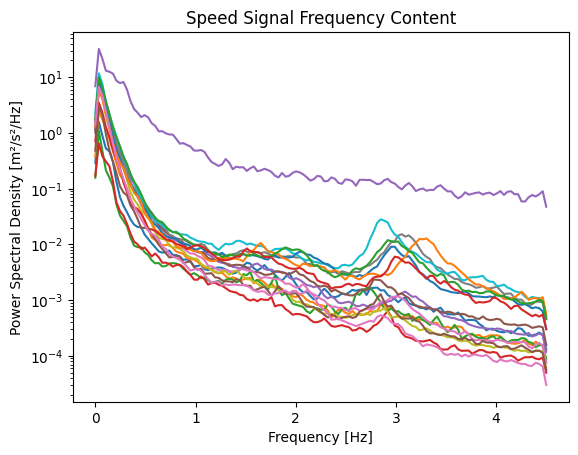

In [49]:
import lib.noise_test as noise

running_weighted_rest_jitter = 0
running_weighted_bad_acceleration_percentage = 0
total_number_of_samples = 0

for pid in participation_ids:
    is_ball = (pid == 'ball')
    participant_df = df[df['participation_id'] == pid]

    if is_ball:
        rest_acceleration_jitter = noise.rest_acceleration_jitter(participant_df['Speed (m/s)'], participant_df['Time (s)'], rest_threshold=0.2)
        bad_acceleration_percentage = noise.bad_acceleration_percentage(participant_df['Speed (m/s)'], participant_df['Time (s)'], max_accel=70.0, max_decel=-80.0)
        print(f"\nBall")
        print(f"Rest acceleration jitter: {rest_acceleration_jitter:.2} m/s²")
        print(f"Bad acceleration percentage: {bad_acceleration_percentage:.2f}%")
    else:
        participant_number_of_samples = participant_df.shape[0]

        rest_acceleration_jitter = noise.rest_acceleration_jitter(participant_df['Speed (m/s)'], participant_df['Time (s)'])
        bad_acceleration_percentage = noise.bad_acceleration_percentage(participant_df['Speed (m/s)'], participant_df['Time (s)'])
        running_weighted_rest_jitter += rest_acceleration_jitter * participant_number_of_samples
        running_weighted_bad_acceleration_percentage += bad_acceleration_percentage * participant_number_of_samples
        total_number_of_samples += participant_number_of_samples    

    noise.power_spectral_density(participant_df['Time (s)'], participant_df['Speed (m/s)'], target_sample_rate=9)

print(f"\nWeighted Player")
print(f"Rest acceleration jitter: {running_weighted_rest_jitter / total_number_of_samples:.2} m/s²")
print(f"Bad acceleration percentage: {running_weighted_bad_acceleration_percentage / total_number_of_samples:.2f}%")

## Data processing
